## 0- Packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RandomizedLasso
from treeinterpreter import treeinterpreter as ti
from graphviz import Source
from IPython.display import SVG,display, Image
from sklearn.tree import export_graphviz
import pydot
from subprocess import call
% matplotlib inline

## 1- Data visualisation

In [8]:
raw_data=pd.read_csv('Telco.csv')
#raw_data.info()

In [9]:
raw_data['TotalCharges']=raw_data['TotalCharges'].convert_objects(convert_numeric=True)
raw_data.dropna(inplace=True)
raw_data.reset_index(inplace=True)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [4]:
# let's work with artificially resampled data for the minority 
#minority=raw_data[raw_data.Churn=='Yes']
#majority=raw_data[raw_data.Churn=='No']
#df_minority_upsampled = resample(minority, 
  #                               replace=True,     
 #                                n_samples=len(majority),    
   #                              random_state=123)
#data_bal=pd.concat([df_minority_upsampled,majority])
#data_bal=data_bal.reset_index()
#del data_bal['index']

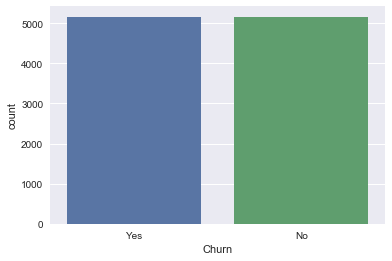

In [63]:
sns.countplot(data_bal['Churn'])

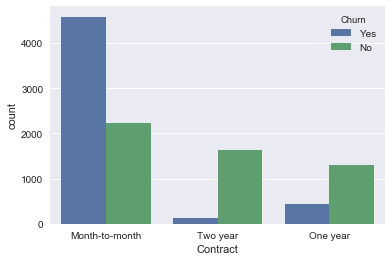

In [64]:
sns.countplot(x='Contract',data=data_bal,hue='Churn')

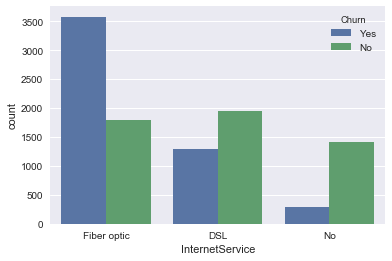

In [65]:
sns.countplot(x='InternetService',data=data_bal,hue='Churn')

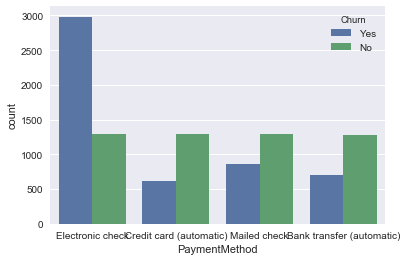

In [66]:
sns.countplot(x='PaymentMethod',data=data_bal,hue='Churn')
# churn très élevés pour les electronic check

## 2- Feature Engineering

### convert cat to dummies

In [10]:
categorical_var=['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

In [13]:
# convert the categorical variables
data_bal=raw_data
data=pd.get_dummies(data_bal[categorical_var],drop_first=True)
data['Churn']=data_bal['Churn']
data['MonthlyCharges']=data_bal['MonthlyCharges']
data['tenure']=data_bal['tenure']
data['TotalCharges']=data_bal['TotalCharges']
data['customerID']=data_bal['customerID'] # here we keep the variable customerID for further interpretation

### remove colinearity for explanatory variables

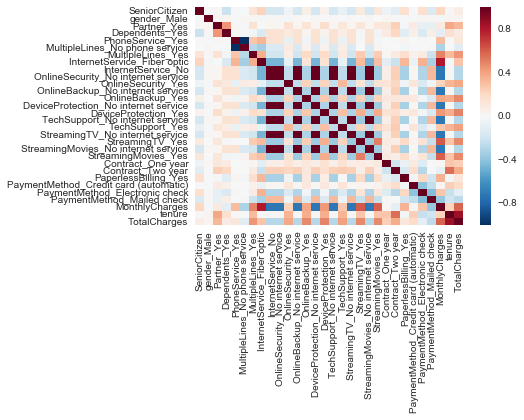

In [281]:
sns.heatmap(data.corr())

In [8]:
def remove_col_var(data,obj,thres):
    d={}
    obj=[obj,'customerID'] # here we keep the variable customerID for further interpretation
    initial_cols=sorted(list(data.drop(obj,axis=1).columns))
    for col in initial_cols:
        d[col]=np.sum(data.drop(obj,axis=1).corr()[col].apply(lambda z : (abs(z)>thres)))
    corr_var=[key for key in d.keys() if d[key]!=1]
    cols=sorted(list(data.drop(obj,axis=1).columns))
    dropped=[]
    while len(cols)>0:
        L=list(data.corr()[abs(data.corr()[cols[-1]])>thres][cols[-1]].index)
        l=list(pd.DataFrame({'value':data.corr()[abs(data.corr()[cols[-1]])>thres][cols[-1]]},index=L).
               sort_values(by='value', axis=0, ascending=False).index)
        
        if l:
            cols=[cols[i] for i in range(len(cols)) if cols[i] not in l]
            dropped.extend(l[1:])
            
    final_cols=[initial_cols[i] for i in range(len(initial_cols)) if initial_cols[i] not in dropped]
    final_cols.extend(obj)
    return ( data[final_cols] )

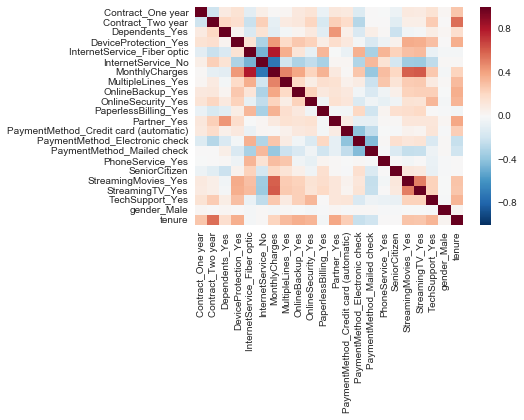

In [280]:
sns.heatmap(remove_col_var(data,'Churn',0.85).corr())

### keep most important features

In [44]:
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))
def keep_important_features(data,obj,thres):
    y=data[obj].apply(lambda z: int(z=='Yes'))
    obj=[obj,'customerID']# here we keep the variable customerID for further interpretation
    X=data.drop(obj,axis=1)
    rlasso = RandomizedLasso(alpha=0.04)
    rlasso.fit(X, y)
    ranks["rlasso/Stability"] = ranking(np.abs(rlasso.scores_), X.columns)
    lr = LinearRegression(normalize=True)
    lr.fit(X,y)
    #stop the search when only the last feature is left
    rfe = RFE(lr, n_features_to_select=1, verbose =3 )
    rfe.fit(X,y)
    ranks["RFE"] = ranking(list(map(float, rfe.ranking_)),  X.columns, order=-1)
    # Using Linear Regression
    lr = LinearRegression(normalize=True)
    lr.fit(X,y)
    ranks["LinReg"] = ranking(np.abs(lr.coef_),  X.columns)

    # Using Ridge 
    ridge = Ridge(alpha = 7)
    ridge.fit(X,y)
    ranks['Ridge'] = ranking(np.abs(ridge.coef_),  X.columns)

    # Using Lasso
    lasso = Lasso(alpha=.05)
    lasso.fit(X, y)
    ranks["Lasso"] = ranking(np.abs(lasso.coef_),  X.columns)

    r={}
    for name in X.columns:
        r[name] = round(np.mean([ranks[method][name] 
                                 for method in ranks.keys()]), 2)

    methods = sorted(ranks.keys())
    ranks["Mean"] = r
    methods.append("Mean")

    meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

    # Sort the dataframe
    meanplot = meanplot.sort_values('Mean Ranking', ascending=False)
    cols_to_keep=meanplot[meanplot['Mean Ranking']>=thres]['Feature']
    l=list(cols_to_keep)
    l.extend(obj)
    return data[l]

### Final data set

In [9]:
#data_f=remove_col_var(keep_important_features(data,'Churn',0.04),'Churn',0.85)
#data_f=remove_col_var(data,'Churn',0.85)

In [15]:
X=data_f
y=data_f['Churn']
y=[int(y[i]=='Yes') for i in range(len(y))]
X_train, X_test, y_train, y_test = train_test_split(X.drop(['Churn','customerID'],axis=1), y, test_size=0.30, random_state=101)

## 3- ML modeling

### get data

In [26]:
raw_data=raw_data.drop(['index','customerID'],axis=1)
data=pd.get_dummies(raw_data)

In [27]:
data=data.drop('Churn_No',axis=1)

In [28]:
X=data.drop('Churn_Yes',axis=1)
y=data['Churn_Yes']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.3,
                                                        stratify=y,
                                                        random_state=1)

In [30]:
from sklearn import preprocessing
std_scale = preprocessing.MinMaxScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

### model 0

In [140]:
clf = LogisticRegression()
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

          0       0.85      0.89      0.87      1549
          1       0.65      0.56      0.60       561

avg / total       0.80      0.80      0.80      2110

[[1384  165]
 [ 248  313]]


### model 1

In [16]:
from sklearn.decomposition import PCA

In [31]:
pca = PCA (n_components=2)

In [32]:
x_pca=pca.fit_transform(X_train)

In [33]:
new_model = LogisticRegression(C=0.1, penalty='l2')
new_model.fit(x_pca,y_train)
#predictions = clf_pca.predict(X_test)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
def plot_2d_space( X , y,new_model):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['.', '+']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title('Classes')
    plt.legend(loc='upper right')
    y_intercept = new_model.intercept_
    slope = new_model.coef_[0][0]
    x_axis = np.linspace(min(X[:,0]), max(X[:,1]), 4922)
    beta_0 = new_model.intercept_
    beta_1 = new_model.coef_[0][0]
    beta_2 = new_model.coef_[0][1]
    y_intercept = -1 * beta_0 / beta_2
    slope = -1 * beta_1 / beta_2
    decisoin_boundary = slope*x_axis + y_intercept
    plt.plot(x_axis, decisoin_boundary, c='b', label='Decision boundary')
    plt.show()

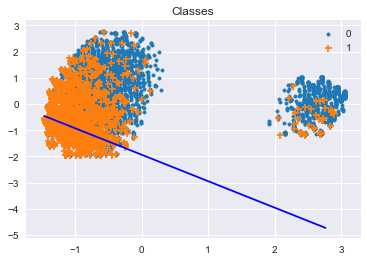

In [34]:
plot_2d_space( x_pca , y_train , new_model)

In [35]:
clf = LogisticRegression(C=0.1, penalty='l2', class_weight='balanced')
clf.fit(x_pca, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

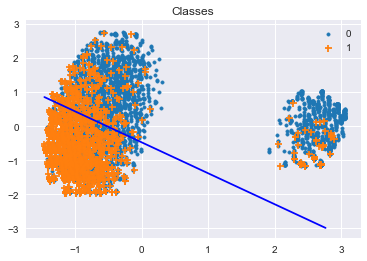

In [36]:
plot_2d_space( x_pca , y_train , clf)

In [214]:
clf = LogisticRegression(C=0.1, penalty='l2', class_weight='balanced')
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
probas=[int((clf.predict_proba(X_test))[i][1] > 0.3) for i in range(len(X_test))]
print(classification_report(y_test,predictions))
print(classification_report(y_test,probas))

print(confusion_matrix(y_test,predictions))
print(confusion_matrix(y_test,probas))

             precision    recall  f1-score   support

          0       0.90      0.72      0.80      1549
          1       0.51      0.79      0.62       561

avg / total       0.80      0.74      0.75      2110

             precision    recall  f1-score   support

          0       0.94      0.53      0.68      1549
          1       0.41      0.91      0.57       561

avg / total       0.80      0.63      0.65      2110

[[1117  432]
 [ 119  442]]
[[817 732]
 [ 51 510]]


In [159]:
## interpretation with ROC and AUC

In [215]:
probs=clf.predict_proba(X_test)
#np.array(probas).reshape(1,-1)

In [208]:
len(probas)

2110

In [209]:
len(y_test)

2110

In [218]:
probs

array([ 0.61911568,  0.70194495,  0.01399428, ...,  0.54508482,
        0.86129681,  0.87942724])

AUC: 0.832


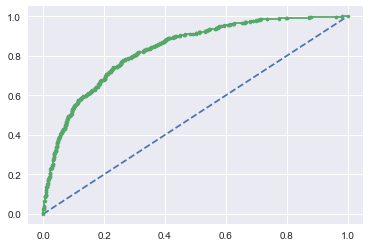

In [219]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
probs=clf.predict_proba(X_test)
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

In [220]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)

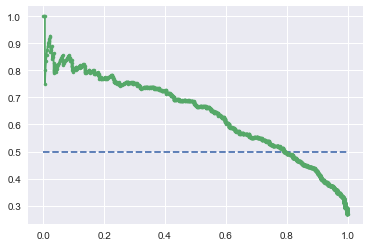

In [224]:
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.show()

In [223]:
for i in range(len(precision)):
    print(' threshold : '+ str(thresholds[i])+ ', precision : ' + str(precision[i]) + ', recall : '+ str(recall[i]))

 threshold : 0.0193198766519, precision : 0.269711538462, recall : 1.0
 threshold : 0.0193251854876, precision : 0.26936026936, recall : 0.998217468806
 threshold : 0.0193302171426, precision : 0.269489894129, recall : 0.998217468806
 threshold : 0.0194630214174, precision : 0.269619643717, recall : 0.998217468806
 threshold : 0.0196620774941, precision : 0.269749518304, recall : 0.998217468806
 threshold : 0.0196769312337, precision : 0.269879518072, recall : 0.998217468806
 threshold : 0.0197662703409, precision : 0.270009643202, recall : 0.998217468806
 threshold : 0.0198513676616, precision : 0.270139893874, recall : 0.998217468806
 threshold : 0.0200986025167, precision : 0.27027027027, recall : 0.998217468806
 threshold : 0.02023152632, precision : 0.270400772574, recall : 0.998217468806
 threshold : 0.0203355825311, precision : 0.270531400966, recall : 0.998217468806
 threshold : 0.0204297246515, precision : 0.270662155631, recall : 0.998217468806
 threshold : 0.0204842005169, p

 threshold : 0.313880420387, precision : 0.415372035977, recall : 0.905525846702
 threshold : 0.314165488031, precision : 0.415711947627, recall : 0.905525846702
 threshold : 0.314447685378, precision : 0.415233415233, recall : 0.903743315508
 threshold : 0.314574846931, precision : 0.415573770492, recall : 0.903743315508
 threshold : 0.315006622821, precision : 0.415914684167, recall : 0.903743315508
 threshold : 0.315245624909, precision : 0.416256157635, recall : 0.903743315508
 threshold : 0.315321458411, precision : 0.416598192276, recall : 0.903743315508
 threshold : 0.315548021182, precision : 0.416940789474, recall : 0.903743315508
 threshold : 0.315744072841, precision : 0.417283950617, recall : 0.903743315508
 threshold : 0.316326055279, precision : 0.4176276771, recall : 0.903743315508
 threshold : 0.316389603213, precision : 0.417971970322, recall : 0.903743315508
 threshold : 0.31688672604, precision : 0.418316831683, recall : 0.903743315508
 threshold : 0.317123850754, pr

IndexError: index 2074 is out of bounds for axis 0 with size 2074

In [90]:
### now let's try with svm rbf kernel

In [154]:
from sklearn import svm
"""param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'class_weight': ['balanced'], 'gamma' : [0.2,0.5,0.8]}
clf = svm.SVC()
gridsearch = GridSearchCV(clf, param_grid)
gridsearch.fit(X_train,y_train)"""

svm = svm.SVC(kernel='rbf', gamma=0.7, C=0.1,  class_weight= 'balanced')
svm.fit(X_train,y_train)
predictions = svm.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

          0       0.84      0.89      0.86      1549
          1       0.62      0.53      0.57       561

avg / total       0.78      0.79      0.78      2110

[[1371  178]
 [ 265  296]]


In [72]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx, yy)


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return (out)

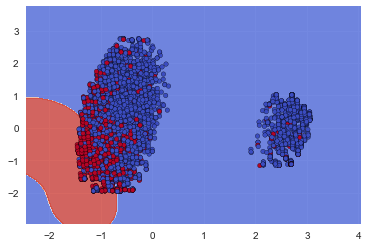

In [107]:
X0, X1 = x_pca[:, 0], x_pca[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(svm, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

### other

In [13]:
from sklearn.learning_curve import validation_curve

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [16]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
clf = LogisticRegression()
gridsearch = GridSearchCV(clf, param_grid)
gridsearch.fit(X_train,y_train)

In [17]:
X_combined_sepal_standard = np.vstack((X_train,X_test))
Y_combined_sepal = np.hstack((y_train, y_test))

In [32]:
train_sepal_scores, test_sepal_scores = validation_curve(estimator=clf
                                                            ,X=X_combined_sepal_standard
                                                            ,y=Y_combined_sepal
                                                            ,param_name='C'
                                                            ,param_range=[0.001,0.01, 0.1, 1, 10, 100]
                                                            )

In [33]:
[abs(np.mean(train_sepal_scores[i])-np.mean(test_sepal_scores[i])) for i in range(6)]

[0.00024210730195606267,
 0.0010652721286075195,
 0.00014526438117368201,
 0.00092000774743372649,
 9.6842920782380659e-05,
 0.00067790044547744177]

In [34]:
[np.mean(test_sepal_scores[i]) for i in range(6)]

[0.74501258957970184,
 0.76196010071663756,
 0.76815804764671702,
 0.76709277551810962,
 0.76660856091419716,
 0.76641487507263217]

In [24]:
[np.mean(test_sepal_scores[i]) for i in range(5)]

[0.76196010071663756,
 0.76815804764671702,
 0.76709277551810962,
 0.76660856091419716,
 0.76641487507263217]

In [35]:
gridsearch.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [36]:
clf = LogisticRegression(C=0.1,penalty='l2')
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)

In [38]:
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

          0       0.79      0.75      0.77      1559
          1       0.76      0.79      0.78      1539

avg / total       0.77      0.77      0.77      3098

[[1170  389]
 [ 316 1223]]


### tree

In [19]:
rfc = RandomForestClassifier(n_estimators=100,bootstrap=False,criterion='gini',max_depth=20,
                             min_samples_split=3)
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)
print(classification_report(y_test,predictions))
print('\n')
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

          0       0.92      0.86      0.89      1559
          1       0.87      0.93      0.90      1539

avg / total       0.90      0.90      0.90      3098



[[1346  213]
 [ 111 1428]]


### SVM

In [225]:
from sklearn.svm import SVC

svm=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
svm.fit(X_train, y_train) 
predictions = svm.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

             precision    recall  f1-score   support

          0       0.79      0.94      0.86      1549
          1       0.64      0.30      0.41       561

avg / total       0.75      0.77      0.74      2110

[[1452   97]
 [ 390  171]]


In [229]:
X1.shape

(2110,)

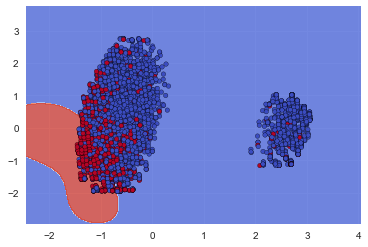

In [233]:
svm.fit(x_pca, y_train)
X0, X1 = x_pca[:, 0], x_pca[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(svm, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

### imblearn

In [4]:
pd.__path__

['/anaconda/lib/python3.6/site-packages/pandas']

In [5]:
import sys
!{sys.executable} -m conda install -c conda-forge imbalanced-learn
#!{sys.executable} -m pip install imblearn
#!conda env list

/anaconda/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Solving environment: \ 

In [60]:
pca_2.explained_variance_ratio_

array([ 0.27847714,  0.13094078])

In [61]:
from imblearn.over_sampling import SMOTE

[(0, 3614), (1, 1308)]
[(0, 2478), (1, 418)]
[(0, 2478), (1, 2478)]


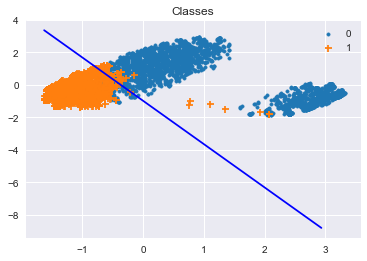

In [62]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours, TomekLinks, NearMiss,  AllKNN
from collections import Counter 
#enn = RepeatedEditedNearestNeighbours()
#tl = TomekLinks(return_indices=False, ratio='majority')
#NM= NearMiss(version=2)
AK= AllKNN(allow_minority=True, sampling_strategy='all')
X_res, y_res = AK.fit_sample(X_train, y_train)
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X_res, y_res)
print(sorted(Counter(y_train).items()))
print(sorted(Counter(y_res).items()))
print(sorted(Counter(y_sm).items()))
pca_2 = PCA (n_components=2)
x_pca_2= pca_2.fit_transform(X_sm)
clf.fit(x_pca_2, y_sm)
plot_2d_space(x_pca_2,y_sm,clf)

In [75]:
#clf = LogisticRegression(C=0.1, penalty='l2', class_weight='balanced')
#clf= RandomForestClassifier()
#from sklearn.svm import SVC
clf = svm=SVC(C=1.0,kernel='rbf',probability=True)
clf.fit(X_sm, y_sm)
predictions = clf.predict(X_test)
probas=[int((clf.predict_proba(X_test))[i][1] > 0.3) for i in range(len(X_test))]
print(classification_report(y_test,predictions))
print(classification_report(y_test,probas))

print(confusion_matrix(y_test,predictions))
print(confusion_matrix(y_test,probas))

             precision    recall  f1-score   support

          0       0.87      0.81      0.84      1549
          1       0.56      0.65      0.60       561

avg / total       0.79      0.77      0.78      2110

             precision    recall  f1-score   support

          0       0.87      0.80      0.83      1549
          1       0.55      0.68      0.61       561

avg / total       0.79      0.76      0.77      2110

[[1261  288]
 [ 194  367]]
[[1233  316]
 [ 180  381]]


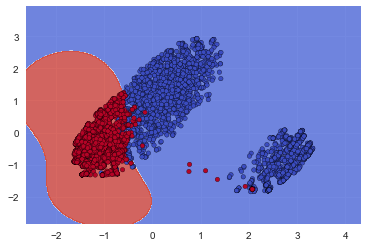

In [76]:
pca_3 = PCA (n_components=2)
x_pca_3= pca_3.fit_transform(X_sm)
svm.fit(x_pca_3, y_sm)

X0, X1 = x_pca_3[:, 0], x_pca_3[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(svm, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X0, X1, c=y_sm, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

## 4- Interpretations - Ad Hoc analysis

### interpretation of a decision tree

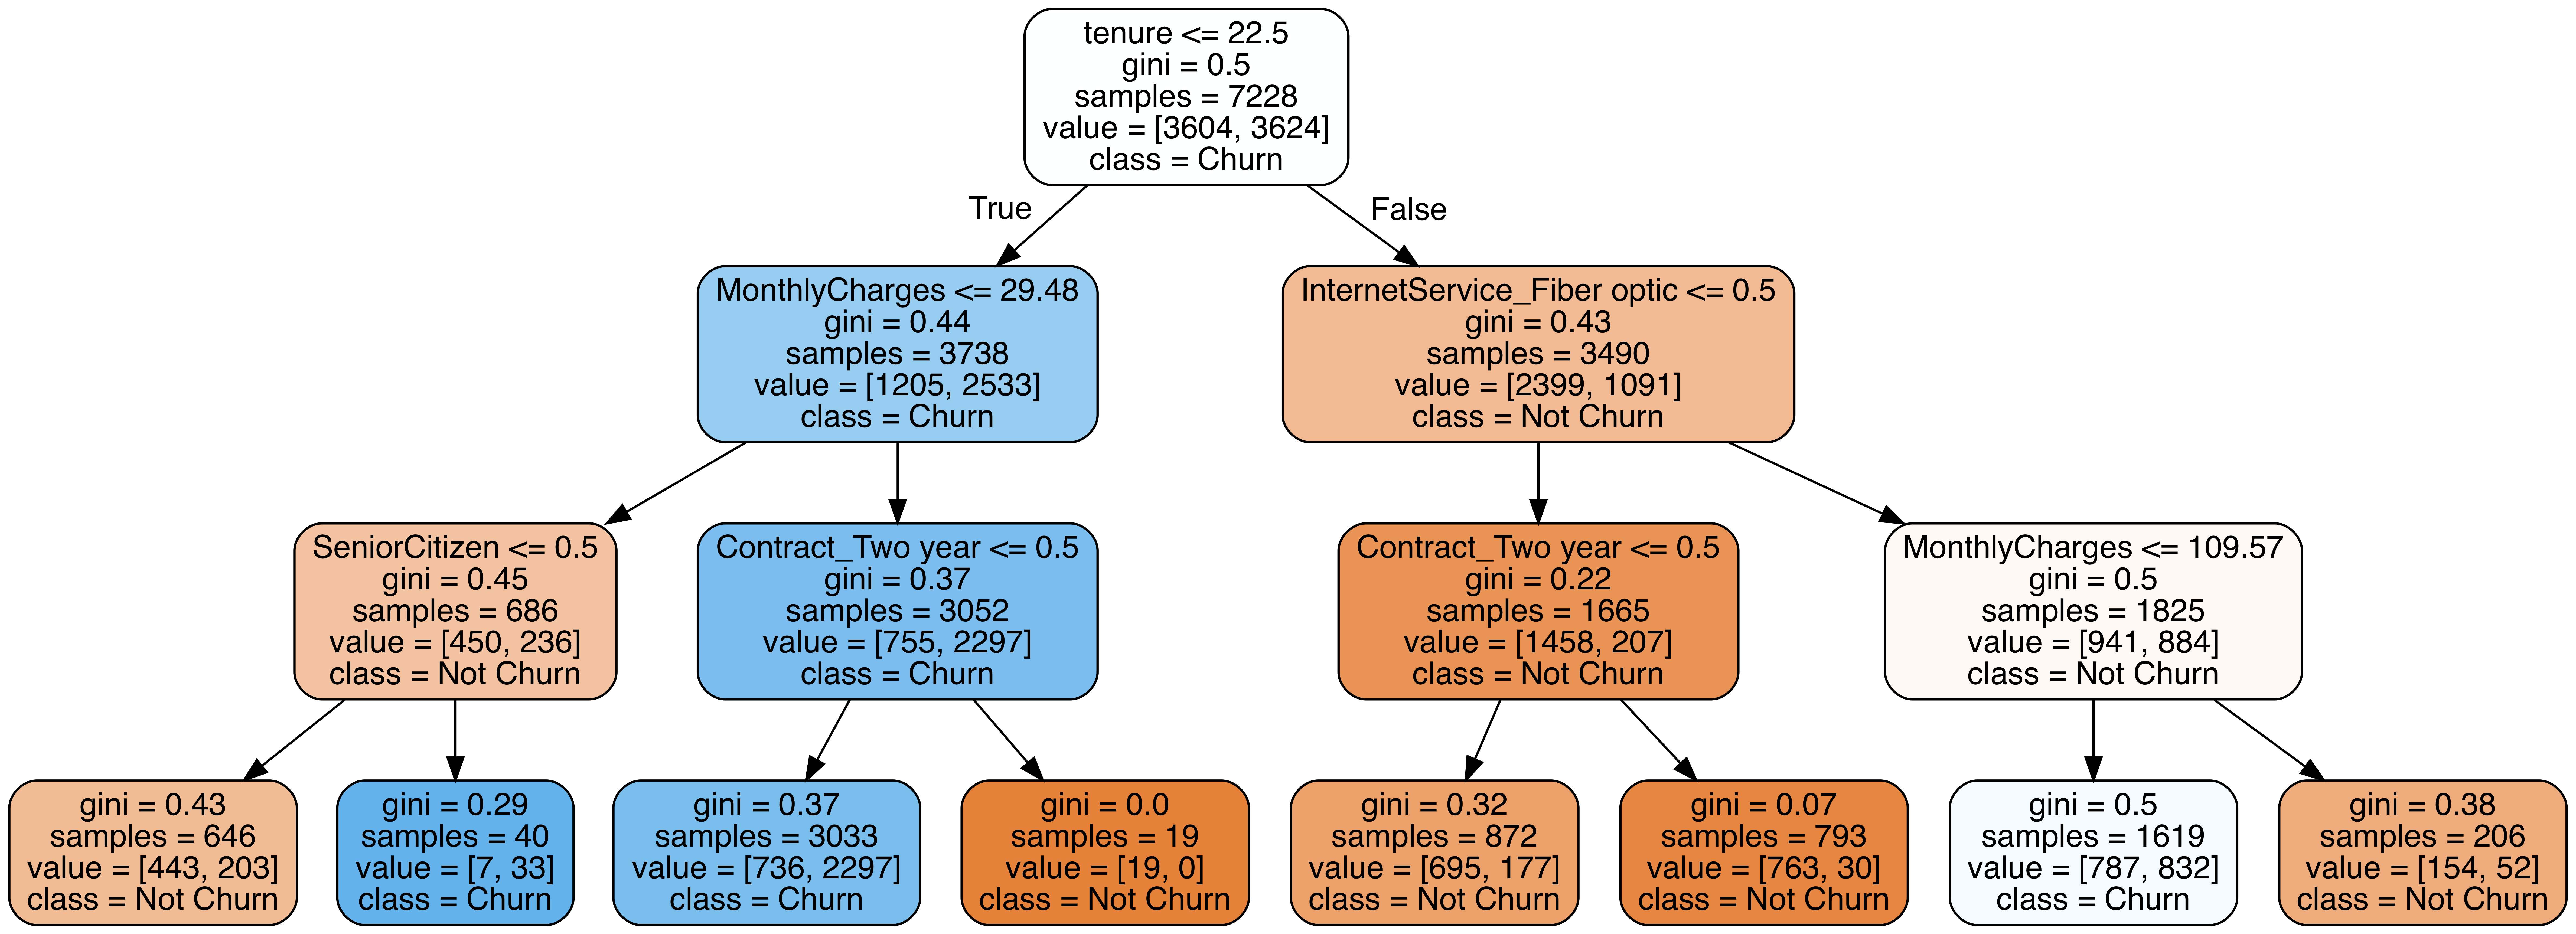

In [38]:
model = RandomForestClassifier(n_estimators=100,bootstrap=False,criterion='gini',max_depth=3,
                             min_samples_split=3)
model.fit(X_train,y_train)
estimator = model.estimators_[98]
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = ['Not Churn','Churn'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
Image(filename = 'tree.png')

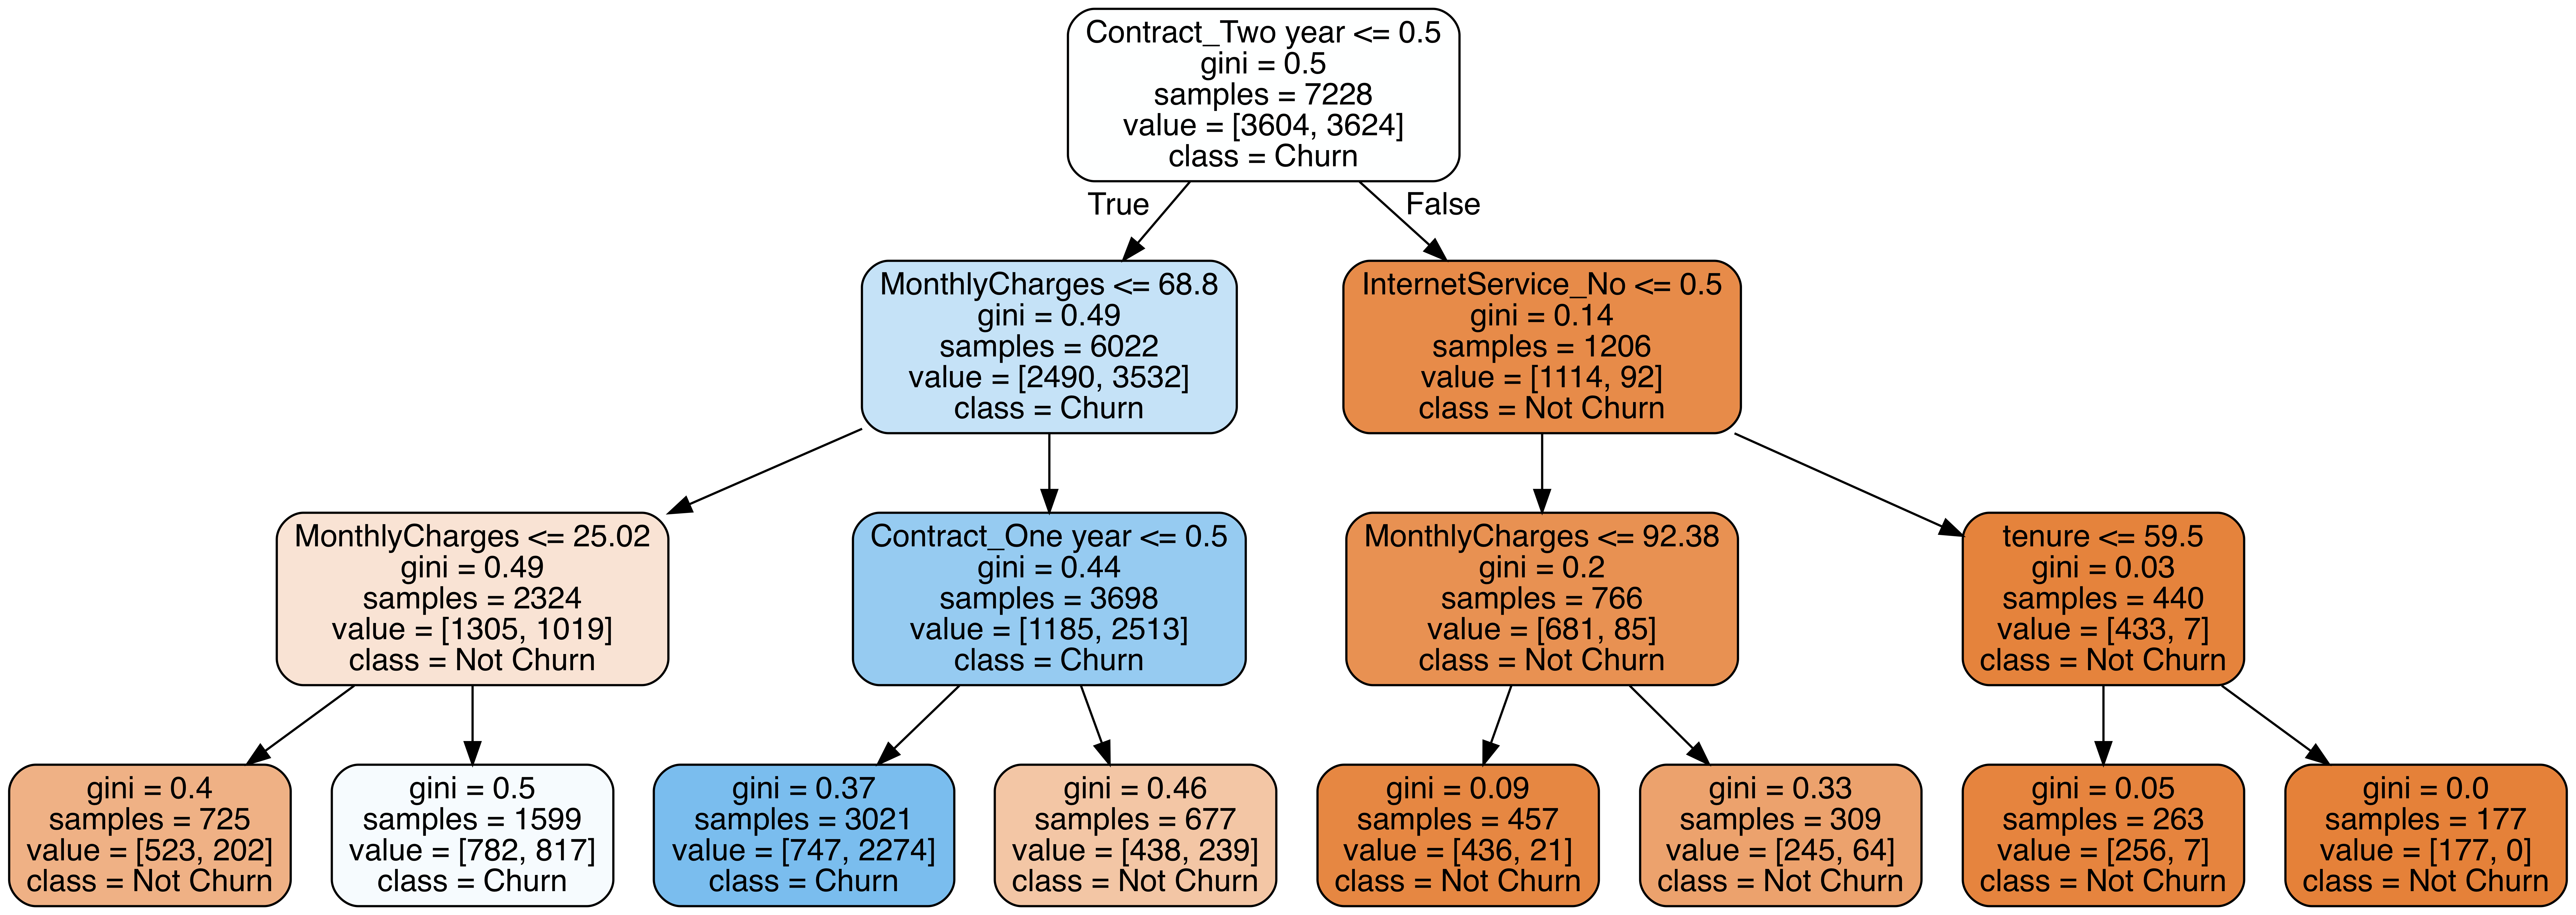

In [33]:
model = RandomForestClassifier(n_estimators=100,bootstrap=False,criterion='gini',max_depth=3,
                             min_samples_split=3)
model.fit(X_train,y_train)
estimator = model.estimators_[99]
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = ['Not Churn','Churn'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
Image(filename = 'tree.png')

### feature importance

In [143]:
d.keys

{'Contract': 0.10334156280220033,
 'Dependents_Yes': 0.021514409030193055,
 'DeviceProtection_Yes': 0.020774522105332916,
 'InternetService': 0.077221375863492814,
 'MonthlyCharges': 0.21665880028135498,
 'MultipleLines_Yes': 0.020748644144998777,
 'OnlineBackup_Yes': 0.024723693433066997,
 'OnlineSecurity_Yes': 0.032786711340094928,
 'PaperlessBilling_Yes': 0.028199522348589409,
 'Partner_Yes': 0.025608073248171603,
 'PaymentMethod': 0.069768411987555193,
 'PhoneService_Yes': 0.0088609892369272587,
 'SeniorCitizen': 0.020863430720099791,
 'StreamingMovies_Yes': 0.019030354897541041,
 'StreamingTV_Yes': 0.019223569383903877,
 'TechSupport_Yes': 0.027756948379938216,
 'gender_Male': 0.031230461417741603,
 'tenure': 0.23168851937879736}

0.698678670313


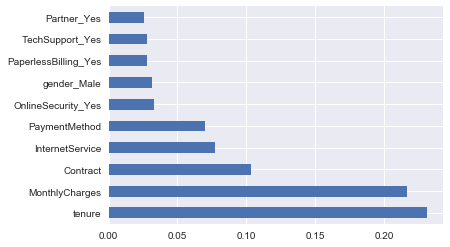

In [142]:
d={}
for (i,j) in zip(list(rfc.feature_importances_),list(X_train.columns)):
    d[j]=i
    
    
d['Contract']=d['Contract_One year']+d['Contract_Two year']
d['InternetService']=d['InternetService_Fiber optic']+d['InternetService_No']
d['PaymentMethod']=d['PaymentMethod_Credit card (automatic)']+d['PaymentMethod_Electronic check']+d['PaymentMethod_Mailed check'] 
del d['Contract_One year'],d['Contract_Two year']
del d['InternetService_Fiber optic'],d['InternetService_No']
del d['PaymentMethod_Credit card (automatic)'],d['PaymentMethod_Electronic check'],d['PaymentMethod_Mailed check']


print(d['Contract']+d['tenure']+d['MonthlyCharges']+d['InternetService']+d['PaymentMethod'])

(pd.Series(list(d.values()), index=list(d.keys()))
   .nlargest(10)
   .plot(kind='barh'))

### How each feature impacts the churn probability?

In [381]:
def compute_contributions(row,var):
    rrow=row.T
    ind=list(X.columns).index(var)
    prediction, bias, contributions = ti.predict(rfc, rrow.reshape(1, -1))
    contrib=contributions[0][ind][1]
    return(contrib)
    #return([zipped[i] for i in range(len(zipped)) if zipped[i][1]==var][0][0])

In [382]:
l=list(X.columns)
l.remove('Churn')
l.remove('customerID')

In [386]:
# let's compute the contributions for 1000 individuals
impacts=X.sample(1000)

In [387]:
var='tenure'
impacts['contrib_'+var]=impacts[l].apply(lambda line:compute_contributions(line,var),axis=1)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


In [389]:
var='MonthlyCharges'
impacts['contrib_'+var]=impacts[l].apply(lambda line:compute_contributions(line,var),axis=1)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


In [ ]:
var='InternetService'
impacts['contrib_'+var]=impacts[l].apply(lambda line:compute_contributions(line,var),axis=1)

In [390]:
impacts.to_csv('impacts_1000.csv')

In [378]:
for var in ['MonthlyCharges','tenure']:
    impacts['contrib_'+var]=impacts[l].apply(lambda line:compute_contributions(line,var),axis=1)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [464]:
impacts['Contract_monthly']=impacts.apply(lambda row: 1 if ((row['Contract_One year']+ row['Contract_Two year'])==0) else 0,axis=1)                                                                                     

In [465]:
impacts['Contract']=impacts.apply(lambda row: 'monthly' if row['Contract_monthly']==1 else row['Contract'], axis=1)
impacts['Contract']=impacts.apply(lambda row: 'one_year' if (row['Contract_One year']==1) else row['Contract'], axis=1)
impacts['Contract']=impacts.apply(lambda row: 'two_year' if (row['Contract_Two year']==1) else row['Contract'], axis=1)

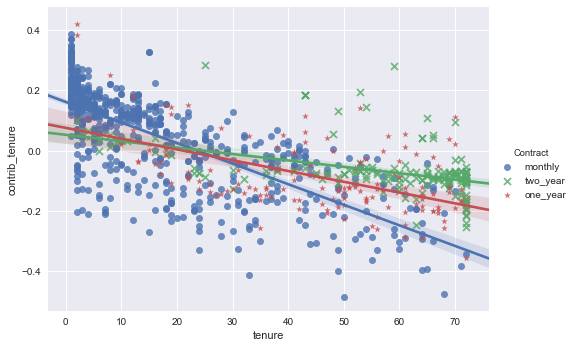

In [490]:
sns.set(rc={'figure.figsize':(21,40)})

sns.lmplot(x="tenure", y="contrib_tenure", 
             data=impacts,hue='Contract',markers=["o", "x","*"],aspect=11.7/8.27)

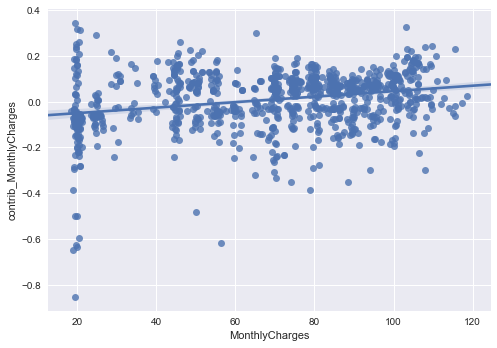

In [493]:
sns.set(rc={'figure.figsize':(21,40)})

sns.lmplot(x="MonthlyCharges", y="contrib_MonthlyCharges", 
             data=impacts,aspect=11.7/8.27)

### Putting all together : unified interpretation

In [ ]:
import shap
X_train_summary = shap.kmeans(X_train, 2)
ex = shap.KernelExplainer(rfc.predict, X_train_summary)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### some examples

In [485]:
# we randomly pick 3 customers
test=X.sort_values(by='customerID').iloc[0:3]

In [486]:
raw_data[raw_data['customerID'].isin(list(test['customerID']))]

index  customerID  gender  SeniorCitizen Partner Dependents  tenure  \
2302   2307  0002-ORFBO  Female              0     Yes        Yes       9   
3482   3488  0003-MKNFE    Male              0      No         No       9   
3838   3845  0004-TLHLJ    Male              0      No         No       4   

     PhoneService MultipleLines InternetService  ...   TechSupport  \
2302          Yes            No             DSL  ...           Yes   
3482          Yes           Yes             DSL  ...            No   
3838          Yes            No     Fiber optic  ...            No   

     StreamingTV StreamingMovies        Contract PaperlessBilling  \
2302         Yes              No        One year              Yes   
3482          No             Yes  Month-to-month               No   
3838          No              No  Month-to-month              Yes   

         PaymentMethod MonthlyCharges TotalCharges Churn  score  
2302      Mailed check           65.6       593.30    No    2.0  
3482      Mailed check           59.9       542.40    No    2.0  
3838  Electronic check           73.9       280.85   Yes    4.5  

[3 rows x 23 columns]

In [487]:
prediction, bias, contributions = ti.predict(rfc, test.drop(['customerID','Churn'],axis=1))

In [488]:
#print ("example", i+1)
print ("Feature contributions")
zipped=zip([contributions[0][j][1] for j in range(len(contributions[0]))], list(X_train.columns))
sorted_zip=sorted(zipped, key=lambda x: -x[0])
for c, feature in sorted_zip:
    print (feature+' : '+ str(c))
print ("-"*20)

Feature contributions
tenure : 0.0821118361105
Contract_Two year : 0.0460973318776
InternetService_No : 0.0218978353235
OnlineSecurity_Yes : 0.0186707933128
PaperlessBilling_Yes : 0.00209830372899
PaymentMethod_Credit card (automatic) : 1.14485964595e-05
MultipleLines_Yes : -0.00184481806853
PhoneService_Yes : -0.00246270757068
SeniorCitizen : -0.00388214313006
DeviceProtection_Yes : -0.008619859251
StreamingTV_Yes : -0.0120689310685
gender_Male : -0.017889859685
PaymentMethod_Mailed check : -0.0192077702278
Partner_Yes : -0.0242661903773
OnlineBackup_Yes : -0.0335598826215
StreamingMovies_Yes : -0.0340915840213
TechSupport_Yes : -0.037372659321
PaymentMethod_Electronic check : -0.0582376565064
Dependents_Yes : -0.0683077223676
InternetService_Fiber optic : -0.070049901262
MonthlyCharges : -0.110910315656
Contract_One year : -0.164499056392
--------------------


In [489]:
for i in range(3):
    print ("example", i+1)
    print ("Feature contributions")
    zipped=zip([contributions[i][j][1] for j in range(len(contributions[0]))], list(X_train.columns))
    sorted_zip=sorted(zipped, key=lambda x: -x[0])
    for c, feature in sorted_zip:
        print (feature+' : '+ str(c))
    print ("-"*20)

example 1
Feature contributions
tenure : 0.0821118361105
Contract_Two year : 0.0460973318776
InternetService_No : 0.0218978353235
OnlineSecurity_Yes : 0.0186707933128
PaperlessBilling_Yes : 0.00209830372899
PaymentMethod_Credit card (automatic) : 1.14485964595e-05
MultipleLines_Yes : -0.00184481806853
PhoneService_Yes : -0.00246270757068
SeniorCitizen : -0.00388214313006
DeviceProtection_Yes : -0.008619859251
StreamingTV_Yes : -0.0120689310685
gender_Male : -0.017889859685
PaymentMethod_Mailed check : -0.0192077702278
Partner_Yes : -0.0242661903773
OnlineBackup_Yes : -0.0335598826215
StreamingMovies_Yes : -0.0340915840213
TechSupport_Yes : -0.037372659321
PaymentMethod_Electronic check : -0.0582376565064
Dependents_Yes : -0.0683077223676
InternetService_Fiber optic : -0.070049901262
MonthlyCharges : -0.110910315656
Contract_One year : -0.164499056392
--------------------
example 2
Feature contributions
Contract_Two year : 0.0466176999974
InternetService_No : 0.0444006277221
Contract_On

In [201]:
def compare_contributions(var,churn):
    churned=X[X.Churn==churn].drop_duplicates(subset='customerID')
    prediction, bias, contributions = ti.predict(rfc, churned.drop(['customerID','Churn'],axis=1))
    distrib=[contributions[i][list(X.columns).index(var)][1] for i in range(len(contributions))]
    sns.distplot(distrib,bins=20)

In [230]:
print(frequency_highest_contrib('tenure','Yes'))
print(frequency_highest_contrib('MonthlyCharges','Yes'))
print(frequency_highest_contrib('PaymentMethod_Electronic check','Yes'))
print(frequency_highest_contrib('InternetService_Fiber optic','Yes'))

0.532267275842
0.280411193604
0.113649343232
0.0348372358652


In [107]:
def frequency_highest_contrib(var,churn):
    churned=X[X.Churn==churn].drop_duplicates(subset='customerID')
    prediction, bias, contributions = ti.predict(rfc, churned.drop(['customerID','Churn'],axis=1))
    n=np.sum([contributions[i][list(X.columns).index(var)][1]==np.max([contributions[i][j][1] for j in range(len(contributions[i]))]) for i in range(len(contributions))])
    return(n/len(churned))

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


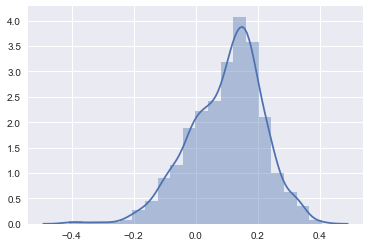

In [202]:
compare_contributions('tenure','Yes')

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


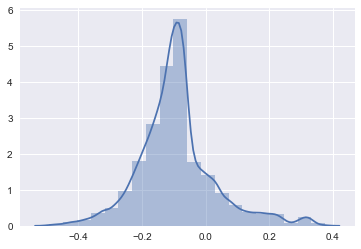

In [203]:
compare_contributions('tenure','No')